In [1]:
import numpy as np
import os
import glob
import cv2
!pip install xmltodict
import xmltodict
import tensorflow as tf
import math
from tqdm import tqdm
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
from keras import layers as layers
from keras import models as models

In [2]:
#download VOC data and extract .tar file
!mkdir train
!mkdir test
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P train/
!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P train/
!wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar -P test/
!tar -xf test/VOCtest_06-Nov-2007.tar -C test/
!tar -xf train/VOCtrainval_06-Nov-2007.tar -C train/
!unzip train/PASCAL_VOC.zip -d train/
!rm -rf train/PASCAL_VOC.zip train/VOCtrainval_06-Nov-2007.tar
!rm -rf test/VOCtest_06-Nov-2007.tar

--2021-12-23 01:04:35--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2021-12-23 01:04:36--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘train/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M   102MB/s    in 4.5s    

2021-12-23 01:04:40 (98.3 MB/s) - ‘train/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2021-12-23 01:04:40--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)...

In [3]:
data_images_path = os.getcwd()+'/train/VOCdevkit/VOC2007/JPEGImages'  # 입력 이미지
data_annotation_path = os.getcwd()+'/train/VOCdevkit/VOC2007/Annotations'  # annotation 파일

img_min=800
img_max=1024
image_height = 1024
image_width  = 1024
image_depth  = 3  # RGB

rpn_kernel_size = 3  # 3x3
subsampled_ratio = [4, 8, 16, 32, 64]  # Pooling 3 times
anchor_sizes = [32, 64, 128, 256, 512]  # Using [128, 256, 512] sizes in 1000x600 img size / Used [32, 64, 128] sizes in 224x224
anchor_aspect_ratio = [[1,1],[1/math.sqrt(2),math.sqrt(2)],[math.sqrt(2),1/math.sqrt(2)]]
num_anchors_in_box = len(anchor_aspect_ratio)

neg_threshold = 0.3
pos_threshold = 0.7
nms_threshold = 0.7
anchor_sampling_amount = 128  # 128 for each positive, negative sampling

In [4]:
list_images = sorted([x for x in glob.glob(data_images_path + '/**')])    
#list_images=list_images[:2000]
total_images = len(list_images)
print('# of total images :', total_images)
list_annotations = sorted([x for x in glob.glob(data_annotation_path + '/**')]) 
#list_annotations = list_annotations[:2000]

# evaluating data consistency between images and annotations 
t1=[]
t2=[]
for i in range(len(list_images)) :
    t1.append(list_images[i][-11:-4])
for i in range(len(list_annotations)) :
    t2.append(list_annotations[i][-11:-4])

for i in range(len(list_annotations)) :
    if t2[i] not in t1 :
        print(list_annotations[i])

print('# of corresponding annotation files :', len(list_annotations))

# of total images : 5011
# of corresponding annotation files : 5011


In [5]:
list_annotations[:3]

['/content/train/VOCdevkit/VOC2007/Annotations/000005.xml',
 '/content/train/VOCdevkit/VOC2007/Annotations/000007.xml',
 '/content/train/VOCdevkit/VOC2007/Annotations/000009.xml']

In [6]:
# xml 파일 살펴보기
f = open('/content/train/VOCdevkit/VOC2007/Annotations/000005.xml')
doc = xmltodict.parse(f.read())
doc

OrderedDict([('annotation',
              OrderedDict([('folder', 'VOC2007'),
                           ('filename', '000005.jpg'),
                           ('source',
                            OrderedDict([('database', 'The VOC2007 Database'),
                                         ('annotation', 'PASCAL VOC2007'),
                                         ('image', 'flickr'),
                                         ('flickrid', '325991873')])),
                           ('owner',
                            OrderedDict([('flickrid', 'archintent louisville'),
                                         ('name', '?')])),
                           ('size',
                            OrderedDict([('width', '500'),
                                         ('height', '375'),
                                         ('depth', '3')])),
                           ('segmented', '0'),
                           ('object',
                            [OrderedDict([('name', 'chair'),
     

In [7]:
def get_classes(xml_files=list_annotations):
    
    classes = []

    for file in xml_files:
        f = open(file)
        # xml 파일을 딕셔너리 형태로
        doc = xmltodict.parse(f.read())
        
        try:
            for obj in doc['annotation']['object']:
                classes.append(obj['name'].lower())

        except TypeError as e:
            classes.append(doc['annotation']['object']['name'].lower())
        
        f.close()

    classes = list(set(classes))
    classes.sort()

    return classes

In [8]:
classes = get_classes(list_annotations)
print('class type :', classes)
num_of_class = len(classes)
print('# of unique classes :', num_of_class)

class type : ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
# of unique classes : 20


In [9]:
def get_labels_from_xml(xml_file_path, num_of_class = num_of_class):
    
    f = open(xml_file_path)
    doc = xmltodict.parse(f.read())

    ori_img_height = float(doc['annotation']['size']['height'])
    ori_img_width = float(doc['annotation']['size']['width'])

    class_label = []
    bbox_label = []
    
    # 이미지에 다수의 object가 존재할 경우
    try:
        for each_obj in doc['annotation']['object']:
            obj_class = each_obj['name'].lower()

            x_min = float(each_obj['bndbox']['xmin'])  # top left x-axis coordinate.
            x_max = float(each_obj['bndbox']['xmax'])  # bottom right x-axis coordinate.
            y_min = float(each_obj['bndbox']['ymin'])  # top left y-axis coordinate.
            y_max = float(each_obj['bndbox']['ymax'])  # bottom right y-axis coordinate.
            
            # scaling (원본 이미지가 224x224로 resize되기 때문에)
            x_min = float((image_width/ori_img_width)*x_min)
            y_min = float((image_height/ori_img_height)*y_min)
            x_max = float((image_width/ori_img_width)*x_max)
            y_max = float((image_height/ori_img_height)*y_max)

            generated_box_info = [x_min, y_min, x_max, y_max]  # ground truth box 좌표

            index = classes.index(obj_class)

            class_label.append(index)
            bbox_label.append(np.asarray(generated_box_info, dtype='float32'))
    
    # 단일 object 처리
    except TypeError as e:
        obj_class = doc['annotation']['object']['name']
        x_min = float(doc['annotation']['object']['bndbox']['xmin']) 
        x_max = float(doc['annotation']['object']['bndbox']['xmax']) 
        y_min = float(doc['annotation']['object']['bndbox']['ymin']) 
        y_max = float(doc['annotation']['object']['bndbox']['ymax']) 

        x_min = float((image_width/ori_img_width)*x_min)
        y_min = float((image_height/ori_img_height)*y_min)
        x_max = float((image_width/ori_img_width)*x_max)
        y_max = float((image_height/ori_img_height)*y_max)

        generated_box_info = [x_min, y_min, x_max, y_max]

        index = classes.index(obj_class) 


        class_label.append(index)
        bbox_label.append(np.asarray(generated_box_info, dtype='float32'))

    return class_label, np.asarray(bbox_label)

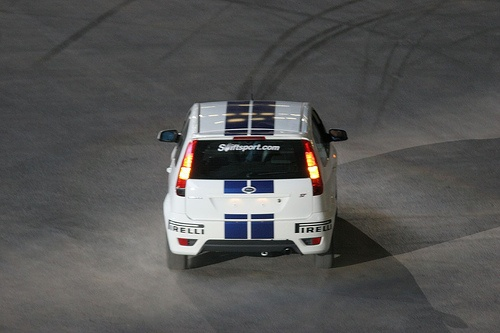

class label : [6]
bbox 좌표 : [[319.488   298.2823  718.848   830.27026]]


In [10]:
# 예시 (single object)
xml_file_path=list_annotations[3]

im = cv2.imread(list_images[3])
cv2_imshow(im)

class_label, bbox_label = get_labels_from_xml(xml_file_path, num_of_class = num_of_class)
print('class label :', class_label)
print('bbox 좌표 :', bbox_label)

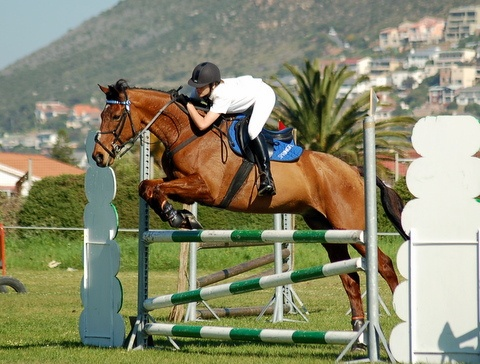

class label : [14, 12]
bbox 좌표 : [[394.66666 174.41759 595.2     559.82416]
 [192.      219.42857 859.73334 945.2308 ]]


In [11]:
# 예시 (multi objects)
xml_file_path=list_annotations[5]

im = cv2.imread(list_images[5])
cv2_imshow(im)

class_label, bbox_label = get_labels_from_xml(xml_file_path, num_of_class = num_of_class)
print('class label :', class_label)
print('bbox 좌표 :', bbox_label)

In [12]:
image_height

1024

In [13]:
def generate_anchors(one_anchor_size, one_subsampled_ratio,
                     rpn_kernel_size=rpn_kernel_size, anchor_aspect_ratio=anchor_aspect_ratio):
    
    list_of_anchors = []  # (x, y, w, h)
    anchor_booleans = []  # masking : 이미지 내부에 있는 anchor들만 사용(1), 나머지는 무시(0)
    
    starting_center = divmod(rpn_kernel_size, 2)[0]
    anchor_center = [starting_center-1, starting_center]

    subsampled_height = image_height / one_subsampled_ratio       
    subsampled_width = image_width / one_subsampled_ratio

    while (anchor_center != [subsampled_width, subsampled_height]):
        anchor_center[0] += 1

        if anchor_center[0] > subsampled_width - (1 + starting_center):
            anchor_center[1] += 1
            anchor_center[0] = starting_center
        
        # Anchors are referenced to the original image. Therefore, multiply downsampling ratio to obtain input image's center 
        anchor_center_on_image = [anchor_center[0]*one_subsampled_ratio, anchor_center[1]*one_subsampled_ratio]

        for size in [one_anchor_size]:
            for a_ratio in anchor_aspect_ratio:
                # [x, y, w, h] -> [y, x, h, w]
                # 동일한 중심점(anchors)에 대해 다양한 scale을 갖는 anchor box 생성
                anchor_info = [anchor_center_on_image[1], anchor_center_on_image[0], size*a_ratio[1], size*a_ratio[0]]
                
                # 이미지 외부의 anchor는 사용 x (0)
                if (anchor_info[0] - anchor_info[2]/2 < 0 or anchor_info[0] + anchor_info[2]/2 > image_width or 
                    anchor_info[1] - anchor_info[3]/2 < 0 or anchor_info[1] + anchor_info[3]/2 > image_height) :

                    anchor_booleans.append([0.0]) 

                else:
                    anchor_booleans.append([1.0])

                list_of_anchors.append(anchor_info)

    return list_of_anchors, anchor_booleans

def generate_pyramid_anchors(anchor_size=anchor_sizes, subsampled_ratio=subsampled_ratio,
                             rpn_kernel_size=rpn_kernel_size, anchor_aspect_ratio=anchor_aspect_ratio):
  
    list_of_anchors, anchor_booleans = [], []
    for i in range(len(anchor_sizes)):
        anchors, bools = generate_anchors(one_subsampled_ratio=subsampled_ratio[i],
                                          one_anchor_size=anchor_sizes[i])
        list_of_anchors.append(anchors)
        anchor_booleans.append(bools)

    return np.concatenate(list_of_anchors, axis=0), np.concatenate(anchor_booleans) 

def normalize_box(anchors) :
    width=anchors[:,3]-anchors[:,1]
    height=anchors[:,2] - anchors[:,0]
    scale=np.array([h-1, w-1, h-1, w-1])
    shift=np.array([0, 0, 1, 1])

    return np.divide((anchors-shift), scale).astype(np.float32)

In [14]:
# generate_pyramid_anchors()

In [15]:
def generate_label(class_labels, ground_truth_boxes, anchors, anchor_booleans, num_class=num_of_class,
                   neg_anchor_thresh = neg_threshold, pos_anchor_thresh = pos_threshold):
  
    number_of_anchors = len(anchors)
    anchor_boolean_array = np.reshape(np.asarray(anchor_booleans), (number_of_anchors, 1))
    
    # 위에서 생성된 anchor에 의해 수많은 영역들이 제안
    objectness_label_array = np.zeros((number_of_anchors, 2), dtype=np.float32)  # object or not
    box_regression_array = np.zeros((number_of_anchors, 4), dtype=np.float32)  # bbox regressor
    class_array = np.zeros((number_of_anchors, num_class), dtype=np.float32)  # label prediction
    
    # 이미지에 존재하는 모든 객체(ground truth bbox)와 anchor들 간의 iou 계산
    for j in range(ground_truth_boxes.shape[0]):
        gt_box_top_left_x = ground_truth_boxes[j][0]
        gt_box_top_left_y = ground_truth_boxes[j][1]
        gt_box_btm_rght_x = ground_truth_boxes[j][2]
        gt_box_btm_rght_y = ground_truth_boxes[j][3]

        gt_box_area = (gt_box_btm_rght_x - gt_box_top_left_x + 1)*(gt_box_btm_rght_y - gt_box_top_left_y + 1)

        for i in range(number_of_anchors):
            # anchor에 대한 masking 고려 (이미지 외부에 있는 anchor는 사용 x)
            if int(anchor_boolean_array[i][0]) == 0:
                continue

        anchor = anchors[i]  # i 번째 valid anchor (1)
        
        # convert format : [x, y, w, h] -> [top-left-x, top-left-y, btm-right-x, btm-right-y]
        anchor_top_left_x = anchor[0] - anchor[2]/2
        anchor_top_left_y = anchor[1] - anchor[3]/2
        anchor_btm_rght_x = anchor[0] + anchor[2]/2
        anchor_btm_rght_y = anchor[1] + anchor[3]/2

        anchor_box_area = (anchor_btm_rght_x - anchor_top_left_x + 1)*(anchor_btm_rght_y - anchor_top_left_y + 1)

        # intersection rectangle  
        int_rect_top_left_x = max(gt_box_top_left_x, anchor_top_left_x)
        int_rect_top_left_y = max(gt_box_top_left_y, anchor_top_left_y)
        int_rect_btm_rght_x = min(gt_box_btm_rght_x, anchor_btm_rght_x)
        int_rect_btm_rght_y = min(gt_box_btm_rght_y, anchor_btm_rght_y)
        
        # iou
        intersect_over_union = float(int_rect_area / (gt_box_area + anchor_box_area - int_rect_area))

        # pos/neg
        if intersect_over_union > pos_anchor_thresh:
            objectness_label_array[i][0] = 1.0 
            objectness_label_array[i][1] = 0.0

            class_label = class_labels[j]
            class_array[i][int(class_label)] = 1.0

            gt_box_center_x = ground_truth_boxes[j][0] + ground_truth_boxes[j][2]/2
            gt_box_center_y = ground_truth_boxes[j][1] + ground_truth_boxes[j][3]/2
            gt_box_width    = ground_truth_boxes[j][2] - ground_truth_boxes[j][0]
            gt_box_height   = ground_truth_boxes[j][3] - ground_truth_boxes[j][1]

            # regression loss
            delta_x = (gt_box_center_x - anchor[0])/anchor[2]
            delta_y = (gt_box_center_y - anchor[1])/anchor[3]
            delta_w = math.log(gt_box_width/anchor[2])
            delta_h = math.log(gt_box_height/anchor[3])

            box_regression_array[i][0] = delta_x
            box_regression_array[i][1] = delta_y
            box_regression_array[i][2] = delta_w
            box_regression_array[i][3] = delta_h
            
        if intersect_over_union <= neg_anchor_thresh:
            if int(objectness_label_array[i][0]) == 0:
                objectness_label_array[i][1] = 1.0

        if intersect_over_union > neg_anchor_thresh and intersect_over_union < pos_anchor_thresh:
            if int(objectness_label_array[i][0]) == 0 and int(objectness_label_array[i][1]) == 0:
                anchor_boolean_array[i][0] = 0.0 # ignore this anchor

    return anchor_boolean_array, objectness_label_array, box_regression_array, class_array

In [16]:
def anchor_sampling(anchor_booleans, objectness_label, anchor_sampling_amount=anchor_sampling_amount):

    positive_count = 0
    negative_count = 0

    for i in range(len(objectness_label.shape[0])):
        # positive anchor
        if int(objectness_label[i][0]) == 1:
            # 지정된 수 만큼의 positive anchor만 샘플링
            if positive_count > anchor_sampling_amount:
                anchor_booleans[i][0] == 0.0

            positive_count += 1

        # negative anchor
        if int(objectness_label[i][1]) == 1:
            # 지정된 수 만큼의 negative anchor만 샘플링
            if negative_count > anchor_sampling_amount:
                anchor_booleans[i][0] = 0.0

            negative_count += 1

    return anchor_booleans            

In [17]:
def generate_dataset(first_index, last_index, anchors, anchor_booleans):
    
    num_of_anchors = len(anchors)

    batch_anchor_booleans = []
    batch_objectness_array  = []
    batch_regression_array  = []
    batch_class_label_array = []
    
    for i in range(first_index, last_index):
        true_labels, ground_truth_boxes = get_labels_from_xml(xml_file_path=list_annotations[i])
        anchor_bools, objectness_label_array, box_regression_array, class_array = generate_label(true_labels, ground_truth_boxes,
                                                                                                 anchors, anchor_booleans)
        anchor_bools = anchor_sampling(anchor_bools, objectness_label_array)

        batch_anchor_booleans.append(anchor_bools)
        batch_objectness_array.append(objectness_label_array)
        batch_regression_array.append(box_regression_array)
        batch_class_label_array.append(class_array)
        
    batch_anchor_booleans = np.reshape(np.asarray(batch_anchor_booleans), (-1,num_of_anchors))          
        
    batch_objectness_array = np.asarray(batch_objectness_array)
    batch_regression_array = np.asarray(batch_regression_array)
    batch_class_label_array = np.asarray(batch_class_label_array)

    return (batch_anchor_booleans, batch_objectness_array, batch_regression_array, batch_class_label_array)

In [18]:
def read_images(first_index, last_index):

    images_list = []
    
    for i in range(first_index, last_index):
        
        im = cv2.imread(list_images[i])
        im = cv2.resize(im, (image_height, image_width)) / 255
        
        images_list.append(im)
    
    return np.asarray(images_list)

In [19]:
# anchors, an_bools = generate_anchors() 
# num_of_anchors = len(anchors)

In [20]:
#a,b,c,d = generate_dataset(0,1, anchors, an_bools)
#a.shape
#print(a)

In [21]:
learning_rate = 1e-5
epoch = 100
batch_size = 10
!mkdir -p '/content/drive/My Drive/VOCdata/trained_weight'
model_checkpoint = './drive/My Drive/VOCdata/trained_weight/model.ckpt'
decay_steps = 10000
decay_rate = 0.99
lambda_value = 10

### Loss

In [22]:
def smooth_func(t):
    t = tf.abs(t)
    
    comparison_tensor = tf.ones((num_of_anchors, 4))
    smoothed = tf.where(tf.less(t, comparison_tensor), 0.5*tf.pow(t,2), t - 0.5)
    
    return smoothed

In [23]:
def smooth_L1(pred_box, truth_box):   
    diff = pred_box - truth_box
    smoothed = tf.map_fn(smooth_func, diff)
    
    return smoothed

### Feature Pyramid by Backbone Network (ResNet)


**ResNet**

![image](https://user-images.githubusercontent.com/44194558/147173025-70f55164-e1f2-4a9c-9b5c-db8ab48cbdb4.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/147050291-a931c8b4-06a7-4f1a-8cb5-8796e8a06cd2.png)

<br/>

![image](https://user-images.githubusercontent.com/44194558/147050407-c839a4b8-af4b-4957-896a-5d0c25b7e02f.png)

<br/>

참고

https://yhkim4504.tistory.com/3

https://wolfy.tistory.com/243

https://eremo2002.tistory.com/76

In [ ]:
# output F(x) + x
def identity_block(input, filter_num):
    y = layers.Conv2D(filter_num[0], (1, 1), strides=(1, 1), padding='valid', use_bias=True)(input)
    y = layers.BatchNormalization(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filter_num[1], (3, 3), strides=(1, 1), padding='same', use_bias=True)(y)
    y = layers.BatchNormalization(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filter_num[2], (1, 1), strides=(1, 1), padding='valid', use_bias=True)(y)
    y = layers.BatchNormalization(y)
    
    # Identity Mapping (Shorcut, Skip Connection)
    # Element wise sum (같은 형상의 matric을 더함)
    y = layers.Add()([y, input])
    y = layers.Activation('relu')(y)
    
    return y

def conv_block(input, filter_num, strides=(2, 2)) :
    y = layers.Conv2D(filter_num[0], (1, 1), strides=strides, padding='valid', use_bias=True)(input)
    y = layers.BatchNormalization(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filter_num[1], (3, 3), strides=(1, 1), padding='same', use_bias=True)(y)
    y = layers.BatchNormalization(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filter_num[2], (1, 1), strides=(1, 1), padding='valid', use_bias=True)(y)
    y = layers.BatchNormalization(y)
    
    # 초기 input에 대해 1x1 convolution 연산 진행 후 F(x)에 더해 줌
    shortcut = layers.Conv2D(filter_num[2], (1, 1), strides=strides, padding='valid', use_bias=True)(input)
    shortcut = layers.BatchNormalization(shortcut)
    
    y = layers.Add()([y, shortcut])
    y = layers.Activation('relu')(shortcut)

    return y

def resnet101(input) :
    # Stage 1
    y = layers.ZeroPadding2D((3, 3))(input)
    y = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='valid', use_bias=True)(y)
    y = layers.BatchNormalization(y)
    y = layers.Activation('relu')(y)
    
    # output of stage 1
    F1=y=layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(y)
    
    # Stage2
    y = conv_block(y, [64, 64, 256], strides=(1, 1))
    y = identity_block(y, [64, 64, 256])    
    
    # output of stage 2
    F2=y=identity_block(y, [64, 64, 256])

    # Stage 3 
    y = conv_block(y, [128, 128, 512])
    y = identity_block(y, [128, 128, 256])    
    y = identity_block(y, [128, 128, 256])
    
    F3=y=identity_block(y, [128, 128, 256])

    # stage 4 : In stage 4, there are 22 identity blocks
    y = conv_block(y, [256, 256, 1024])
    block_num = 22
    for i in range(block_num) :
        y = identity_block(y, [256, 256, 1024])
    F4 = y
    
    # stage 5 
    y = conv_block(y, [512, 512, 2048])
    y = identity_block(y, [512, 512, 2048])
    
    F5=y=identity_block(y, [512, 512, 2048])

    return [F1, F2, F3, F4, F5]  # feature pyramid

### FPN

<br/>

임의 크기의 single scale 이미지를 입력하여 다양한 scale의 feature map을 출력 (ResNet 이용)

 - layer 별로 feature map을 추출하여 수정하는 네트워크


![image](https://user-images.githubusercontent.com/44194558/147052982-ce545be3-dea8-485f-bd8f-db6a996b97d4.png)

<br/>


![image](https://user-images.githubusercontent.com/44194558/147174393-f04e875e-3c5f-44de-a5a2-2651c25a05b1.png)

 - 각 pyramid level의 feature map을 2배로 upsampling하고 channel 수를 동일하게 맞춤

In [ ]:
def fpn(input) :
    P5 = layers.Conv2d(256, (1, 1))(F5)
    P5 = layers.Conv2D(256, (3, 3), padding='same')(P5)
    # Compute P4 by adding feature map4 and Upsampled result of P5
    res4 = layers.UpSammpling2D(size=(2, 2))(P5)
    P4 = layers.Add([res4, layers.Conv2D(256, (1, 1)(F4))])
    P4 = layers.Conv2D(256, (3, 3), padding='same')(P4)

    res3 = layers.UpSammpling2D(size=(2, 2))(P4)
    P3 = layers.Add([res4, layers.Conv2D(256, (1, 1)(F3))])
    P3 = layers.Conv2D(256, (3, 3), padding='same')(P3)

    res2 = layers.UpSammpling2D(size=(2, 2))(P3)
    P2 = layers.Add([res4, layers.Conv2D(256, (1, 1)(F2))])
    P2 = layers.Conv2D(256, (3, 3), padding='same')(P2)

    #Issues : Why use (1, 1) for pool size and reason for not computing (3, 3) conv only in P6
    P6 = layers.MaxPooling2D(pool_size=(1, 1), strides=2)(P5)

    return [P2, P3, P4, P5, P6]

### RPN

Feature pyramid 별로 RPN에 입력하여 objectness score, bbox regression을 가진 region proposal을 출력

In [ ]:
def rpn(input) :
    # All of feature map's depth in FPN is 256
    input_featuremap = layers.Input(shape=[None, None, 256])
    shared4obj_and_bb = layers.Conv2d(512, (3, 3), padding='same', activation_fn='relu', strides=1)(input)
    obj_conv = layers.Conv2d(6, (1, 1), padding='VALID', activation_fn='linear')(shared4obj_and_bb)  # None * None * 6
    bb_conv = layers.Conv2d(12, (1, 1), padding='VALID', activation_fn='linear')(shared4obj_and_bb)  # None * None * 12

    class_conv_reshape = tf.reshape(obj_conv, (-1, num_of_anchors, 2))  # 6084x2
    anchor_conv_reshape = tf.reshape(bb_conv, (-1, num_of_anchors, 4))  # 6084x4

    logits = tf.nn.softmax(class_conv_reshape)
    
    return models.Model([input_featuremap], [class_conv_reshape, logits, anchor_conv_reshape])

In [25]:
def apply_box_delta(boxes, delta) : 
    '''
    Input : boxes [N, [y1, x1, y2, x2]]
    boxes = anchor boxes (ranked top k of All anchors) 
    delta = correspondents to anchor boxes' delta (also ranked top k anchors' delta)

    apply delta to boxes (* refined boxes' coordinates represent normalized coordinates)
    '''
    y1, x1, y2, x2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    anchor_height = y2 - y1
    anchor_width = x2 - x1
    anchor_center_x = x1 + width*0.5
    anchor_center_y = y1 + height*0.5

    # apply delta to box
    refined_center_x = delta[:,1] * width + anchor_center_x
    refined_center_y = delta[:,0] * height + anchor_center_y
    refined_width = tf.exp(delta[:,3]) * anchor_width
    refined_height = tf.exp(delta[:,2]) * anchor_height

    # compute refined coordinates : [y1, x1, y2, x2]
    refined_x1 = refined_center_x - 0.5*width
    refined_x2 = refined_center_x + 0.5*width
    refined_y1 = refined_center_y - 0.5*height
    refined_y2 = refined_center_y + 0.5*height

    return tf.stack([refined_y1, refined_x1, refined_y2, refined_x2], axis=1)

In [26]:
def compute_iou_boxes(one_box, boxes, box_area, boxes_area) :
    intersection_y1 = np.maximum(box[0], boxes[:, 0])
    intersection_x1 = np.maximum(box[1], boxes[:, 1])
    intersection_y2 = np.minimum(box[2], boxes[:, 2])
    intersection_x2 = np.minimum(box[3], boxes[:, 3])

    inter_area = np.maximum(intersection_x2 - intersection_x1, 0) * np.maximum(intersection_y1 - intersection_y2, 0)
    union_area = box_area + boxes_area[:] - inter_area
    iou = inter_area / union_area
    
    return iou

def non_max_suppression(boxes, scores) : 
    # scores : result from softmax of rpn's output(logits)
    y1 = boxes[:, 0]
    x1 = boxes[:, 1]
    y2 = boxes[:, 2]
    x2 = boxes[:, 3]
    area = (y2 - y1) * (x2 - x1)

    # Use fg score to sort
    sorted_idx = scores.argsort()[::-1]         # return idx of sorted result
    
    result = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = sorted_idx[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
        # Identify boxes with IoU over the 0.7(nms_threshold). 
        # This returns are correspondents to ixs[1:], so add 1 (ixs are correspondents to ixis[:]).
        remove_ixs = np.where(iou > nms_threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    nms_roi = tf.gather(boxes, result)
    
    return nms_roi

In [ ]:
# Loss Function
loss1 = 1/256*tf.reduce_sum(anch_bool*(tf.nn.softmax_cross_entropy_with_logits(labels=Y_obj, logits=class_conv_reshape))) # positive(128) + negative(128)
# (10, 6084, 2)
loss2 = lambda_value*(1/128)*tf.reduce_sum((tf.reshape(Y_obj[:,:,0], (-1,num_of_anchors,1)))*smooth_L1(anchor_conv_reshape, Y_coor))

total_loss = loss1 + loss2

optimizer = tf.train.AdamOptimizer(decayed_lr).minimize(total_loss, global_step=global_step)

global_step = tf.Variable(0, trainable=False)
decayed_lr = tf.train.exponential_decay(learning_rate,
                                            global_step, decay_steps,
                                            decay_rate, staircase=True)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

try:
    saver.restore(sess, model_checkpoint)
    print("Model has been loaded!")
    
except:
    
    print("Model doens't exist!")